# ECE 580 Project Code (New Data)

## Fake News Detection using SVM and TF-IDF

- Rebecca Du (rrd17)
- Anish Parmar (avp30)

## Notebook Overview

In this notebook, we assess the performance of our best **Logistic Regression and Linear SVM** models on a new dataset

We employ the following setup:
- **Model**: Logistic Regression, SVM (Linear Kernel)
- **Vectorizers**: Hybrid TF-IDF Vectorizer, Bigram TF-IDF Vectorizer
- **Stopwords**: Removed

## Imports

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion

In [5]:
#Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rebec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1: Data Preprocessing

## Overview:

To further test the model  the [fake_real_news_dataset](https://github.com/GeorgeMcIntire/fake_real_news_dataset/tree/main). It is a dataset formed of 1 CSV files of real and fake news.

- **Real news**: $50\%$ of the dataset are random real news articles from sources such as the New York Times, Wall Street Journal, Bloomberg, NPR, and The Guardian which were published in 2015 or 2016.
- **Fake news**: $50\%$ of the dataset are random articles from the [Getting Real about Fake News](https://www.kaggle.com/datasets/mrisdal/fake-news) dataset, which itself contains text and metadata scraped from $244$ fake news websites tagged by the BS Detector Chrome Extension. The data comes from the 2016 election cycle.

Each data point contains the following features:
- **idd**: A unique ID used to identify the article
- **title**: The title of the article
- **text**: The full body of text of the article
- **label**: The label of the article as either REAL or FAKE news

## Step 1a: Load, Prune, Relabel Dataset

Since the fake and true data has been combined into one dataset already, we load it and turn it into a dataframe. 

Then, we prune any NaN values.

Finally, we relabel it for our models.

In [9]:
#Load datasets as dataframes
data = pd.read_csv('new_data/fake_and_real_news_dataset.csv')

In [10]:
#Check data
data

,idd,title,text,label
0,Fq+C96tcx+,‘A target on Roe v. Wade ’: Oklahoma bill maki...,UPDATE: Gov. Fallin vetoed the bill on Friday....,REAL
1,bHUqK!pgmv,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,REAL
2,4Y4Ubf%aTi,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",REAL
3,_CoY89SJ@K,Grand jury in Texas indicts activists behind P...,A Houston grand jury investigating criminal al...,REAL
4,+rJHoRQVLe,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,REAL
...,...,...,...,...
4589,ukZm6JTO#x,Russia Calls the War Party's Bluff,License DMCA \nCold War 2.0 has reached unprec...,FAKE
4590,yu0xKEiapJ,Bernie Sanders: The Democratic primary gave me...,Print \nSen. Bernie Sanders laid out the ways ...,FAKE
4591,c4Y370E_9c,"Pipeline Police Strip Search Native Girl, Then...",As the pressure to start construction on the D...,FAKE
4592,bBbeuCUeMH,Currency Crisis: Alasdair MacLeod On The Vexed...,Tweet Home » Gold » Gold News » Currency Crisi...,FAKE


In [11]:
#Count how many NaN values there are and where they are located
data.isna().sum()

idd      0
title    1
text     0
label    0
dtype: int64

In [12]:
#Drop rows with NaN, check NaN sum again
data = data.dropna()
data.isna().sum()

idd      0
title    0
text     0
label    0
dtype: int64

In [13]:
#Count how many real and fake data points there are
data['label'].value_counts()

label
FAKE    2297
REAL    2296
Name: count, dtype: int64

In [14]:
#Label fake_df values as '0', true_df values as '1'
data['label'] = data['label'].map({'FAKE': 0, 'REAL': 1})

#Check data
data

C:\Users\rebec\AppData\Local\Temp\ipykernel_2924\1901363885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['label'].map({'FAKE': 0, 'REAL': 1})


,idd,title,text,label
0,Fq+C96tcx+,‘A target on Roe v. Wade ’: Oklahoma bill maki...,UPDATE: Gov. Fallin vetoed the bill on Friday....,1
1,bHUqK!pgmv,Study: women had to drive 4 times farther afte...,Ever since Texas laws closed about half of the...,1
2,4Y4Ubf%aTi,"Trump, Clinton clash in dueling DC speeches","Donald Trump and Hillary Clinton, now at the s...",1
3,_CoY89SJ@K,Grand jury in Texas indicts activists behind P...,A Houston grand jury investigating criminal al...,1
4,+rJHoRQVLe,"As Reproductive Rights Hang In The Balance, De...",WASHINGTON -- Forty-three years after the Supr...,1
...,...,...,...,...
4589,ukZm6JTO#x,Russia Calls the War Party's Bluff,License DMCA \nCold War 2.0 has reached unprec...,0
4590,yu0xKEiapJ,Bernie Sanders: The Democratic primary gave me...,Print \nSen. Bernie Sanders laid out the ways ...,0
4591,c4Y370E_9c,"Pipeline Police Strip Search Native Girl, Then...",As the pressure to start construction on the D...,0
4592,bBbeuCUeMH,Currency Crisis: Alasdair MacLeod On The Vexed...,Tweet Home » Gold » Gold News » Currency Crisi...,0


## Step 1b: Combine Relevant Columns into 'Content'

Since we are mostly focused on the content of the articles, we will combine the title with the text columns and drop everything except the 'content' and 'label' columns.

In [16]:
#Combine title and text into 'content' column
data['content'] = data['title'] + ' ' + data['text']

#Drop other columns (except for label)
data = data.drop(columns=['title', 'text', 'idd'])

#Check data
data

C:\Users\rebec\AppData\Local\Temp\ipykernel_2924\3740435099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['content'] = data['title'] + ' ' + data['text']


,label,content
0,1,‘A target on Roe v. Wade ’: Oklahoma bill maki...
1,1,Study: women had to drive 4 times farther afte...
2,1,"Trump, Clinton clash in dueling DC speeches Do..."
3,1,Grand jury in Texas indicts activists behind P...
4,1,"As Reproductive Rights Hang In The Balance, De..."
...,...,...
4589,0,Russia Calls the War Party's Bluff License DMC...
4590,0,Bernie Sanders: The Democratic primary gave me...
4591,0,"Pipeline Police Strip Search Native Girl, Then..."
4592,0,Currency Crisis: Alasdair MacLeod On The Vexed...


In [17]:
preprocessed_data = data
with_stopwords_data = data

## Step 1c: Text Cleaning

Next, we will do some simple cleaning of the 'content' column:
- Convert it to lowercase
- Remove punctuation
- Remove stopwords

In [19]:
#Create a function for the data preprocessing tasks
def preprocessing(text):
    #Turn to lowercase
    text = text.lower()

    #Remove punctuation 
    text = re.sub(r'[^\w\s]', '', text)

    #Remove stopwords
    #Split text into individual words
    split_text = text.split()
    cleaned_text = []
    
    for word in split_text:
        if word not in stop_words:
            #Only keep non-stop word words
            cleaned_text.append(word)

    #Recombine into one string
    rejoined_text = ' '.join(cleaned_text)

    return rejoined_text

In [20]:
def preprocessing_no_stopwords_removal(text):
    # Turn to lowercase
    text = text.lower()

    # Remove punctuation (keeps only word characters and spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Optional: Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [21]:
#Apply preprocessing function to data
preprocessed_data['content'] = preprocessed_data['content'].apply(preprocessing)

#Check to make sure it looks right
preprocessed_data

,label,content
0,1,target roe v wade oklahoma bill making felony ...
1,1,study women drive 4 times farther texas laws c...
2,1,trump clinton clash dueling dc speeches donald...
3,1,grand jury texas indicts activists behind plan...
4,1,reproductive rights hang balance debate modera...
...,...,...
4589,0,russia calls war partys bluff license dmca col...
4590,0,bernie sanders democratic primary gave leverag...
4591,0,pipeline police strip search native girl leave...
4592,0,currency crisis alasdair macleod vexed questio...


In [22]:
#Data with stopwords
with_stopwords_data['content'] = with_stopwords_data['content'].apply(preprocessing_no_stopwords_removal)

with_stopwords_data

,label,content
0,1,target roe v wade oklahoma bill making felony ...
1,1,study women drive 4 times farther texas laws c...
2,1,trump clinton clash dueling dc speeches donald...
3,1,grand jury texas indicts activists behind plan...
4,1,reproductive rights hang balance debate modera...
...,...,...
4589,0,russia calls war partys bluff license dmca col...
4590,0,bernie sanders democratic primary gave leverag...
4591,0,pipeline police strip search native girl leave...
4592,0,currency crisis alasdair macleod vexed questio...


## Step 1d: Train/Validation/Test Splitting

Now, we will split our cleaned data into training, validation, and testing sets. This will be useful for tuning hyperparameters and assessing model performance later on. 

The split we will choose is: 
- **Train**: 70%
- **Validation**: 15%
- **Test**: 15%

In [24]:
#Split into features (X) and labels (y)
X = preprocessed_data['content']
y = preprocessed_data['label']

In [25]:
# Split into train and temp 
train, temp_data = train_test_split(preprocessed_data, test_size=0.3, stratify=data['label'], random_state=42)

# Split temp into validation & test
val, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Get features and labels for each split
X_train_preproc, y_train_preproc = train['content'], train['label']
X_val_preproc, y_val_preproc = val['content'], val['label']
X_test_preproc, y_test_preproc = test['content'], test['label']

In [26]:
# Display the distribution of Fake and Real News in nonprocessed and processed datasets after splitting

print("Processed Data Train, Validation, & Test Distribution")
print("Train Labels:", y_train_preproc.value_counts(normalize=True))
print("Validation Labels:", y_val_preproc.value_counts(normalize=True))
print("Test Labels:", y_test_preproc.value_counts(normalize=True))

Processed Data Train, Validation, & Test Distribution
Train Labels: label
0    0.500156
1    0.499844
Name: proportion, dtype: float64
Validation Labels: label
1    0.500726
0    0.499274
Name: proportion, dtype: float64
Test Labels: label
0    0.500726
1    0.499274
Name: proportion, dtype: float64


In [27]:
#Split into features (X) and labels (y)
X = with_stopwords_data['content']
y = with_stopwords_data['label']

In [28]:
# Split into train and temp 
train, temp_data = train_test_split(with_stopwords_data, test_size=0.3, stratify=data['label'], random_state=42)

# Split temp into validation & test
val, test = train_test_split(temp_data, test_size=0.5, stratify=temp_data['label'], random_state=42)

# Get features and labels for each split
X_train_stopword, y_train_stopword = train['content'], train['label']
X_val_stopword, y_val_stopword = val['content'], val['label']
X_test_stopword, y_test_stopword = test['content'], test['label']

In [29]:
# Display the distribution of Fake and Real News in nonprocessed and processed datasets after splitting

print("Processed Data Train, Validation, & Test Distribution")
print("Train Labels:", y_train_stopword.value_counts(normalize=True))
print("Validation Labels:", y_val_stopword.value_counts(normalize=True))
print("Test Labels:", y_test_stopword.value_counts(normalize=True))

Processed Data Train, Validation, & Test Distribution
Train Labels: label
0    0.500156
1    0.499844
Name: proportion, dtype: float64
Validation Labels: label
1    0.500726
0    0.499274
Name: proportion, dtype: float64
Test Labels: label
0    0.500726
1    0.499274
Name: proportion, dtype: float64


## Step 2: Trying Different N-Gram TF-IDF Vectorizers

**TF-IDF** is a combination of 2 terms:
- **Term Frequency (TF)**: how frequently a term appears in one given document ($d$), calculated as:
$$
\text{TF(term, document)} = \frac{\text{Number of times the term appears in the document}}{\text{Total number of terms in the document}}
$$

- **Inverse Document Frequency (IDF)**: how unique the term ($t$) is across all the documents ($d$), calculated as:
$$
\text{IDF(term, corpus)} = \log \left( \frac{\text{Total number of documents}}{\text{1 + Number of documents containing the term}} \right)
$$

In practice, TF-IDF is a weighting technique that **gives higher weight to**:
- **High TF score** (frequent in one document)
- and **Low IDF score** (not too common across all documents)

Here, we will experiment with different **N-Grams**, including:
- **Character-level N-Grams** (groups of frequently occurring characters, size 3-5)
- **Hybrid N-Gram** (a combination of word and character vectorizers)

**We will fit the vectorizer on the training data only** to avoid 'cheating' (aka allowing the model to learn from the data in the validation/testing sets, which would give it an unfair advantage in later testing). We will then transform all the splits.

In [31]:
#Character-level vectorizer
vectorizer_char_level_ngrams = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5)
)

In [32]:
# Bigram vectorizer WITHOUT stopwords
vectorizer_bigrams = TfidfVectorizer(
    ngram_range=(1, 2),      
    stop_words='english'
)

In [33]:
# Word-level TF-IDF (unigrams and bigrams)
# unigrams and bigrams
# remove stopwords for word-level
word_vectorizer = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),      
    stop_words='english'     
)

# Character-level TF-IDF (trigrams to 5-grams)
# character n-grams within word boundaries
# char trigrams to 5-grams
# don't remove stopwords here
char_vectorizer = TfidfVectorizer(
    analyzer='char_wb',      
    ngram_range=(3, 5),      
    stop_words=None          
)

# combine both 
hybrid_vectorizer = FeatureUnion([
    ("word_tfidf", word_vectorizer),
    ("char_tfidf", char_vectorizer)
])

In [34]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = vectorizer_bigrams.fit_transform(X_train_preproc)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = vectorizer_bigrams.transform(X_val_preproc)
X_test_tfidf = vectorizer_bigrams.transform(X_test_preproc)

## Step 2b: Apply Vectorizers on Data and Assess Models

In [36]:
# Create function for calculating and printing precision, recall, f1 score, & confusion matrix 
# (only called for test set)
def model_evaluation(test, pred, name:string):
    precision = precision_score(test, pred)
    recall = recall_score(test, pred)
    f1 = f1_score(test, pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    print(f"\n{name} Classification Report:")
    print(classification_report(test, pred))

    cm = confusion_matrix(test, pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.xlabel(f'Predicted Labels ({name})')
    plt.ylabel('True Labels')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

## Logistic Regression w/Character-Level TF-IDF (With Stopwords)

Precision: 0.899135446685879
Recall: 0.9069767441860465
F1 Score: 0.9030390738060782

Logistic Regression (Character-Level N-Gram) Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       345
           1       0.90      0.91      0.90       344

    accuracy                           0.90       689
   macro avg       0.90      0.90      0.90       689
weighted avg       0.90      0.90      0.90       689



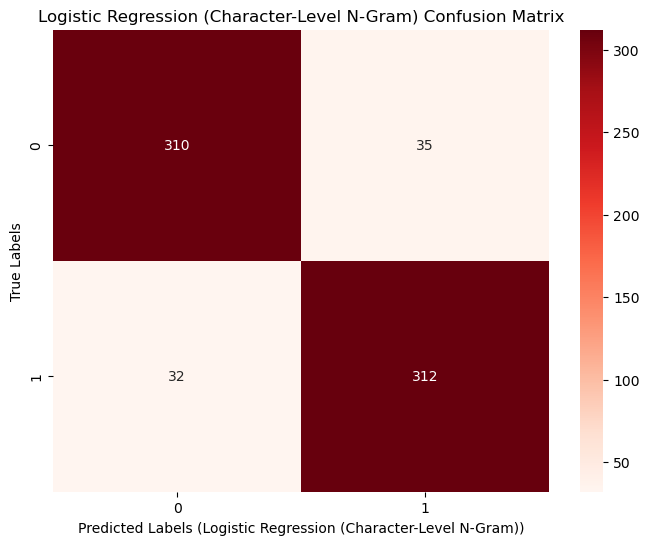

Logistic Regression (Character-Level N-Gram) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       344
           1       0.91      0.94      0.92       345

    accuracy                           0.92       689
   macro avg       0.92      0.92      0.92       689
weighted avg       0.92      0.92      0.92       689



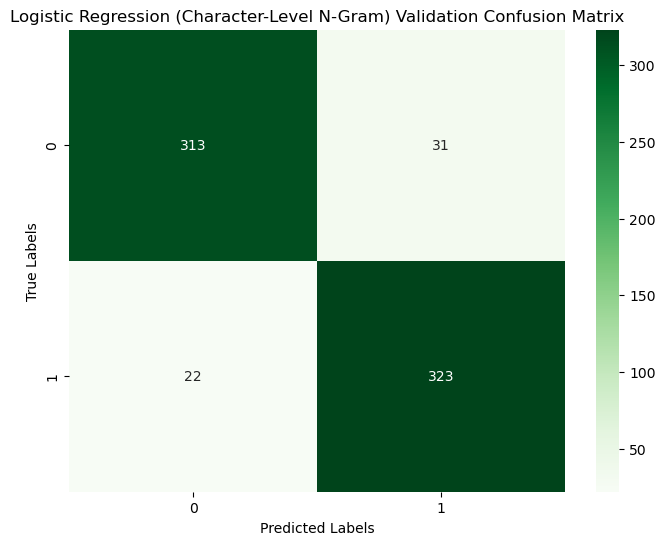

In [38]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train_stopword)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_stopword, lr_y_pred, "Logistic Regression (Character-Level N-Gram)")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (Character-Level N-Gram) Validation Classification Report:")
print(classification_report(y_val_stopword, y_val_pred))

cm_val = confusion_matrix(y_val_stopword, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (Character-Level N-Gram) Validation Confusion Matrix')
plt.show()

## Logistic Regression w/Hybrid TF-IDF 

In [40]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = hybrid_vectorizer.fit_transform(X_train_stopword)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = hybrid_vectorizer.transform(X_val_stopword)
X_test_tfidf = hybrid_vectorizer.transform(X_test_stopword)

Precision: 0.9283582089552239
Recall: 0.9040697674418605
F1 Score: 0.9160530191458026

Logistic Regression (Hybrid N-Gram) Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       345
           1       0.93      0.90      0.92       344

    accuracy                           0.92       689
   macro avg       0.92      0.92      0.92       689
weighted avg       0.92      0.92      0.92       689



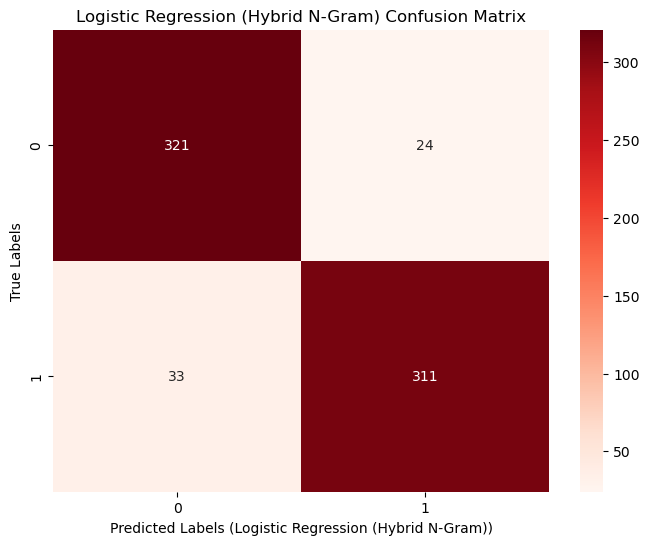

Logistic Regression (Hybrid N-Gram) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       344
           1       0.94      0.94      0.94       345

    accuracy                           0.94       689
   macro avg       0.94      0.94      0.94       689
weighted avg       0.94      0.94      0.94       689



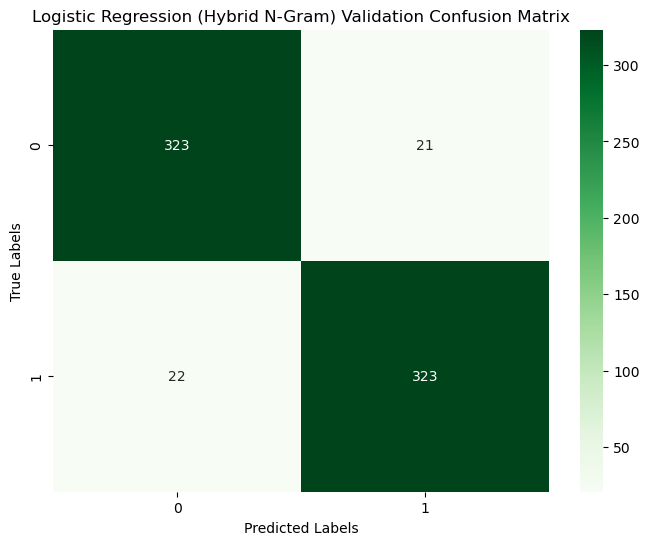

In [41]:
# Initialize & train Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_tfidf, y_train_stopword)

# Make predictions on test set
lr_y_pred = logistic_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_stopword, lr_y_pred, "Logistic Regression (Hybrid N-Gram)")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_tfidf)
print("Logistic Regression (Hybrid N-Gram) Validation Classification Report:")
print(classification_report(y_val_stopword, y_val_pred))

cm_val = confusion_matrix(y_val_stopword, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (Hybrid N-Gram) Validation Confusion Matrix')
plt.show()

## Logistic Regression w/CountVectorizer

In [43]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_counts = vectorizer.fit_transform(X_train_preproc)

# Transform the validation and test data
X_val_counts = vectorizer.transform(X_val_preproc)
X_test_counts = vectorizer.transform(X_test_preproc)

Precision: 0.9418960244648318
Recall: 0.8953488372093024
F1 Score: 0.9180327868852459

Logistic Regression (CountVectorizer) Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       345
           1       0.94      0.90      0.92       344

    accuracy                           0.92       689
   macro avg       0.92      0.92      0.92       689
weighted avg       0.92      0.92      0.92       689



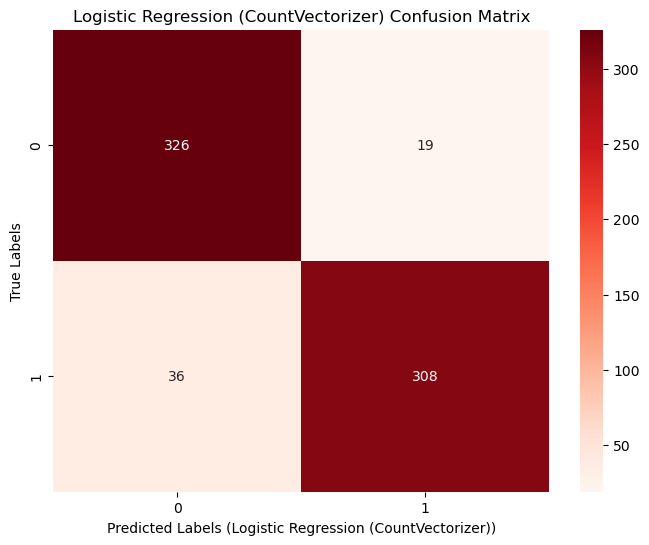

Logistic Regression (CountVectorizer) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       344
           1       0.94      0.94      0.94       345

    accuracy                           0.94       689
   macro avg       0.94      0.94      0.94       689
weighted avg       0.94      0.94      0.94       689



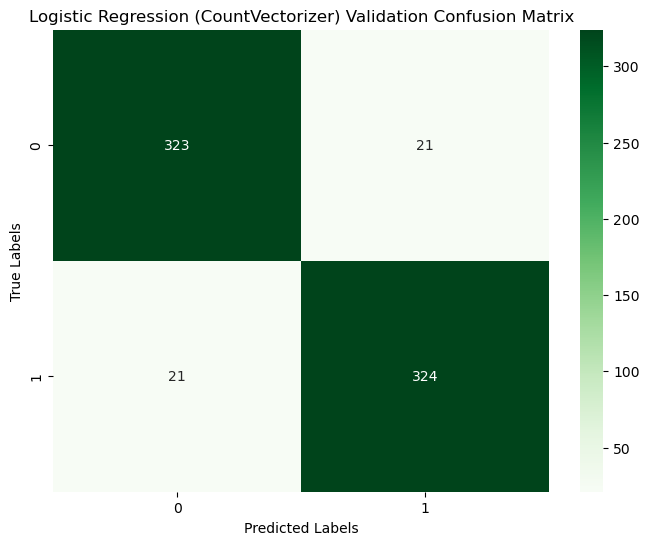

In [44]:
# With Count Vectorizer
logistic_model = LogisticRegression(max_iter=1000, random_state=42)  
logistic_model.fit(X_train_counts, y_train_preproc)

lr_y_pred = logistic_model.predict(X_test_counts)

model_evaluation(y_test_preproc, lr_y_pred, "Logistic Regression (CountVectorizer)")

# Validation set evaluation
y_val_pred = logistic_model.predict(X_val_counts)
print("Logistic Regression (CountVectorizer) Validation Classification Report:")
print(classification_report(y_val_preproc, y_val_pred))

cm_val = confusion_matrix(y_val_preproc, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression (CountVectorizer) Validation Confusion Matrix')
plt.show()

## Linear SVM w/Character-Level TF-IDF (With Stopwords)

In [76]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = vectorizer_char_level_ngrams.fit_transform(X_train_stopword)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = vectorizer_char_level_ngrams.transform(X_val_stopword)
X_test_tfidf = vectorizer_char_level_ngrams.transform(X_test_stopword)

Precision: 0.9404761904761905
Recall: 0.9186046511627907
F1 Score: 0.9294117647058824

Linear SVM (Character-Level N-Gram) Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       345
           1       0.94      0.92      0.93       344

    accuracy                           0.93       689
   macro avg       0.93      0.93      0.93       689
weighted avg       0.93      0.93      0.93       689



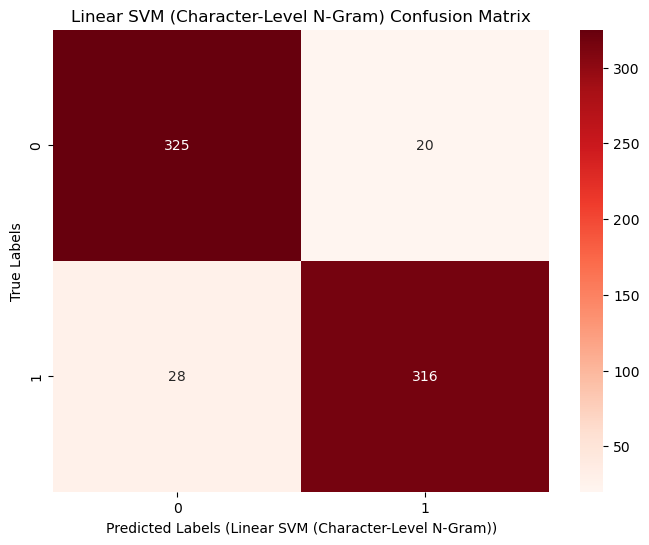

Linear SVM (Character-Level N-Gram) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       344
           1       0.93      0.95      0.94       345

    accuracy                           0.94       689
   macro avg       0.94      0.94      0.94       689
weighted avg       0.94      0.94      0.94       689



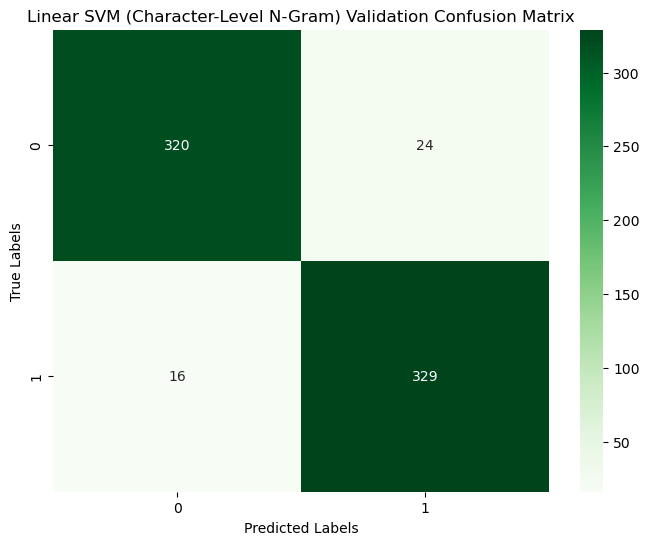

In [77]:
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_tfidf, y_train_stopword)  

# Predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_stopword, y_pred, "Linear SVM (Character-Level N-Gram)")

# Validation set evaluation
y_val_pred = svm_model.predict(X_val_tfidf)
print("Linear SVM (Character-Level N-Gram) Validation Classification Report:")
print(classification_report(y_val_stopword, y_val_pred))

cm_val = confusion_matrix(y_val_stopword, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Linear SVM (Character-Level N-Gram) Validation Confusion Matrix')
plt.show()

## Linear SVM w/Hybrid TF-IDF

In [79]:
#Fit vectorizer on training data ONLY and transform
X_train_tfidf = hybrid_vectorizer.fit_transform(X_train_stopword)

#Transform (NO FITTING TO AVOID CHEATING) validation, test sets
X_val_tfidf = hybrid_vectorizer.transform(X_val_stopword)
X_test_tfidf = hybrid_vectorizer.transform(X_test_stopword)

Precision: 0.9497041420118343
Recall: 0.9331395348837209
F1 Score: 0.9413489736070382

Linear SVM (Hybrid N-Gram) Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       345
           1       0.95      0.93      0.94       344

    accuracy                           0.94       689
   macro avg       0.94      0.94      0.94       689
weighted avg       0.94      0.94      0.94       689



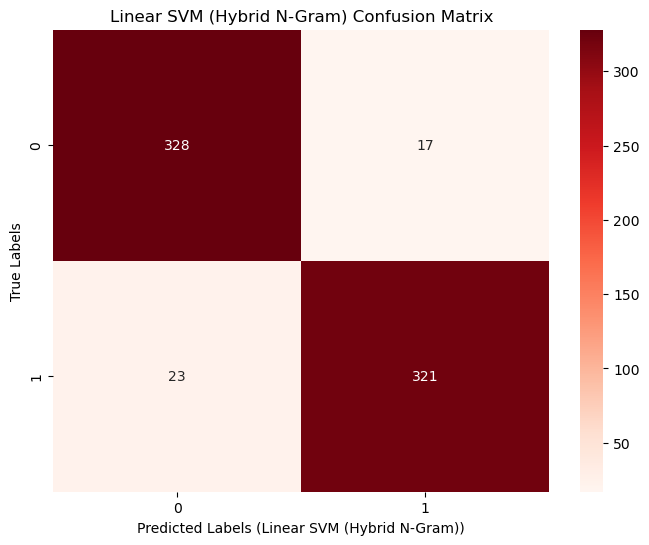

Linear SVM (Hybrid N-Gram) Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       344
           1       0.94      0.96      0.95       345

    accuracy                           0.95       689
   macro avg       0.95      0.95      0.95       689
weighted avg       0.95      0.95      0.95       689



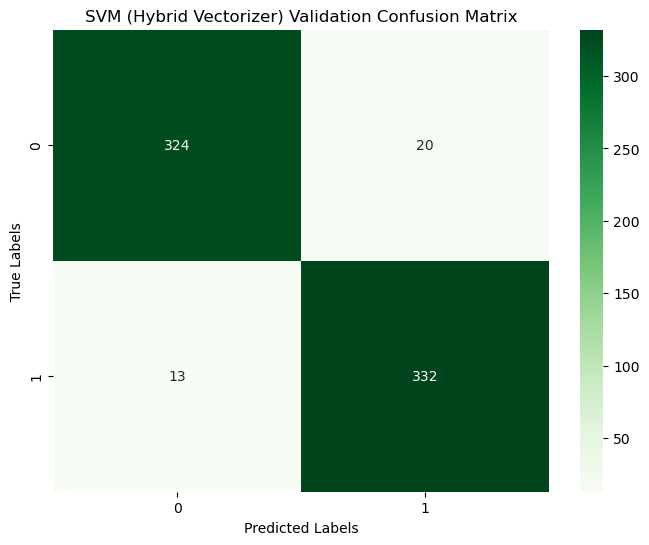

In [80]:
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_tfidf, y_train_stopword)  

# Predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)

# Evaluate model
model_evaluation(y_test_stopword, y_pred, "Linear SVM (Hybrid N-Gram)")

# Validation set evaluation
y_val_pred = svm_model.predict(X_val_tfidf)
print("Linear SVM (Hybrid N-Gram) Validation Classification Report:")
print(classification_report(y_val_stopword, y_val_pred))

cm_val = confusion_matrix(y_val_stopword, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM (Hybrid Vectorizer) Validation Confusion Matrix')
plt.show()

## Linear SVM w/CountVectorizer

In [81]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_counts = vectorizer.fit_transform(X_train_preproc)

# Transform the validation and test data
X_val_counts = vectorizer.transform(X_val_preproc)
X_test_counts = vectorizer.transform(X_test_preproc)

In [82]:
# With Count Vectorizer
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_counts, y_train)

# Predictions on the test set
y_pred = svm_model.predict(X_test_counts)

model_evaluation(y_test_preproc, y_pred, "SVM")

# Validation set evaluation
y_val_pred = svm_model.predict(X_val_counts)
print("SVM (CountVectorizer) Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('SVM (CountVectorizer) Validation Confusion Matrix')
plt.show()

NameError: name 'y_train' is not defined